# Web scraping Project + ML - Consumer Research and ML model to predict consumer sentiment

<h3> Importing Libraries </h3>

In [3]:
import pandas as pd
from bs4 import BeautifulSoup
import requests
import numpy as np
import matplotlib.pyplot as plt
from time import sleep
from random import randint
from selenium import webdriver
import re
import time
from datetime import datetime
import psycopg2
import time
import nltk
nltk.download('punkt')
import nltk.corpus
from nltk.tokenize import word_tokenize
from nltk.util import bigrams, trigrams, ngrams
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
word_lem = WordNetLemmatizer()
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import ensemble
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, plot_confusion_matrix
from sklearn.naive_bayes import MultinomialNB
import joblib
from collections import OrderedDict

<h3> Capturing and storing url links from relevant websites for later web-scraping</h3>

In [311]:
def url_compiler(link, num_link):

    pages = [i for i in range(num_link)]
    print("First Task: Capturing URLs of pages...")
    PATH = "/usr/local/chromedriver"
    option = webdriver.ChromeOptions()
    option.add_argument('headless')
    urls = [link]
    vendor_name = re.findall('review/www.([a-zA-Z]+).', link)[0].title()
    print(f"Capturing URLs for {vendor_name} Pages...")
    start_time = time.time()
    
    for page in range(len(pages)):
        driver = webdriver.Chrome(PATH, options=option)
        driver.get(f"{urls[page]}")
        sleep(5)
        bs = BeautifulSoup(driver.page_source, 'html.parser')
        driver.quit() 

        repository = bs.find_all(class_='company-profile-body')

        for i in repository:
            next_page_link = 'https://www.trustpilot.com' + str(i.nav.a['href'])
            urls.append(next_page_link)
        print(f"Link {page} captured...")

    end_time = time.time()

    print(f"Total time taken to capture all the page URLs for {vendor_name}: {(end_time-start_time)/60} minutes")
    print()
    return urls

vendor_url_list = [("https://www.trustpilot.com/review/www.acitydiscount.com", 200), ("https://www.trustpilot.com/review/juneoven.com", 46), ("https://www.trustpilot.com/review/artydome.com", 115)]

url_all = []

for url, total_pages in vendor_url_list:
    url_all.extend(url_compiler(url, total_pages))

First Task: Capturing URLs of pages...
Capturing URLs for Beliani Pages...
Link 0 captured...
Link 1 captured...
Link 2 captured...
Link 3 captured...
Link 4 captured...
Link 5 captured...
Link 6 captured...
Link 7 captured...
Link 8 captured...
Link 9 captured...
Link 10 captured...
Link 11 captured...
Link 12 captured...
Link 13 captured...
Link 14 captured...
Link 15 captured...
Link 16 captured...
Link 17 captured...
Link 18 captured...
Link 19 captured...
Link 20 captured...
Link 21 captured...
Link 22 captured...
Link 23 captured...
Link 24 captured...
Link 25 captured...
Link 26 captured...
Link 27 captured...
Link 28 captured...
Link 29 captured...
Link 30 captured...
Link 31 captured...
Link 32 captured...
Link 33 captured...
Link 34 captured...
Link 35 captured...
Link 36 captured...
Link 37 captured...
Link 38 captured...
Link 39 captured...
Link 40 captured...
Link 41 captured...
Link 42 captured...
Link 43 captured...
Link 44 captured...
Link 45 captured...
Link 46 capture

<h3>Gathering all data from url links and exporting to SQL database</h3>
<h4>Below are list of items to be exported..</h4>
<li>username</li>
<li>review title</li>
<li>review description</li>
<li>date of post</li>
<li>rating</li>

In [312]:
def data_collection(url_list):

    PATH = "/usr/local/chromedriver"
    option = webdriver.ChromeOptions()
    option.add_argument('headless')
    
    start_time = time.time()
    query = 'INSERT INTO consumer VALUES '
    print("Second Task: Gathering all the data...")
    
    for index, url in enumerate(url_list):
        driver = webdriver.Chrome(PATH, options=option)
        driver.get(f"{url}")
        sleep(5)
        bs = BeautifulSoup(driver.page_source, 'html.parser')
        driver.quit()     

        review = bs.find_all(class_="review-card")

        for i in review:
            # Going to store all this data into SQL. We need to replace single apostrophes with double in order to upload into SQL successfully
            # without error. 
            username = i.find(class_='consumer-information__name').text.strip().replace("'", '"').title()
            review = i.find('a', class_='link link--large link--dark').text.strip().replace("'", '"')
            if i.find(class_='review-content__text') is not None:
                desc = i.find('p', class_='review-content__text').text.strip().replace("'", '"')
            else:
                desc = 'No description'
            location = i.find(class_='consumer-information__location').span.text.strip()
            date = re.findall('([0-9-]+)T', i.time['datetime'])[0]
            rating = re.findall('([0-9])', i.img['alt'])[0]
            
            query += "('{0}', '{1}', '{2}', '{3}', {4}, '{5}'),".format(username, review, desc, location, int(rating), date)
        
        print(f"Page {index} extracted...")    
    
    print("All data captured...")
    query = query.strip(',') + ';'
    
    end_time = time.time()
    print(f"Total time taken to capture all the data: {round((end_time-start_time)/60, 2)} minutes")
    print()
    return query

query = data_collection(url_list2)

Second Task: Gathering all the data...
Page 0 extracted...
Page 1 extracted...
Page 2 extracted...
Page 3 extracted...
Page 4 extracted...
Page 5 extracted...
Page 6 extracted...
Page 7 extracted...
Page 8 extracted...
Page 9 extracted...
Page 10 extracted...
Page 11 extracted...
Page 12 extracted...
Page 13 extracted...
Page 14 extracted...
Page 15 extracted...
Page 16 extracted...
Page 17 extracted...
Page 18 extracted...
Page 19 extracted...
Page 20 extracted...
Page 21 extracted...
Page 22 extracted...
Page 23 extracted...
Page 24 extracted...
Page 25 extracted...
Page 26 extracted...
Page 27 extracted...
Page 28 extracted...
Page 29 extracted...
Page 30 extracted...
Page 31 extracted...
Page 32 extracted...
Page 33 extracted...
Page 34 extracted...
Page 35 extracted...
Page 36 extracted...
Page 37 extracted...
Page 38 extracted...
Page 39 extracted...
Page 40 extracted...
Page 41 extracted...
Page 42 extracted...
Page 43 extracted...
Page 44 extracted...
Page 45 extracted...
Page 

<h3>Initiate SQL connection with python and begin inserting data into SQL database</h3>

In [314]:
import psycopg2

password = open('sql_password.txt', 'r').read()
conn = psycopg2.connect("dbname=consumer_research user=postgres password={0}".format(password))
cursor = conn.cursor()

start_time = time.time()
print("Writing into SQL...")
cursor.execute(query)
conn.commit()
end_time = time.time()
print(f"Total time taken to write data into SQL table: {round((end_time-start_time)*1000, 2)} msecs")
cursor.close()
conn.close()

Total time taken to write data into SQL table: 39.86 msecs


<h3>Retrieving data from SQL</h3>

In [450]:
conn = psycopg2.connect("dbname=consumer_research user=postgres password={0}".format(password))
cursor = conn.cursor()

query = "SELECT * FROM consumer2;"
cursor.execute(query)

user = []
review = []
location = []
rating = []
date_posted = []

data = cursor.fetchall()

for i in data:
    user.append(i[0])
    review.append(i[1])
    location.append(i[2])
    rating.append(i[3])
    date_posted.append(i[4])

cursor.close()
conn.close()

# acity_df = pd.DataFrame({
#     'User': user,
#     'Review': review,
#     'Location': location,
#     'Rating': rating,
#     'Date': date_posted
# })
reviews_df = pd.DataFrame({
    'User': user,
    'Review': review,
    'Location': location,
    'Rating': rating,
    'Date': date_posted
})

In [451]:
reviews_df

,User,Review,Location,Rating,Date
0,Chocolate Heaven Co.,"Bought Fagor Dishmachine, haven""t had long eno...",US,5,2021-07-15
1,Culinary Concepts & Consulting,These guys are always helpful and priced right...,US,5,2021-07-15
2,Johnnie M,Nothing but great experience with this store.,US,5,2021-07-15
3,Mister Ice Cream,The unit was delivered in a timely manner. The...,US,5,2021-07-14
4,Juan B Galli,Excellent service and fast response,US,5,2021-07-14
...,...,...,...,...,...
8655,Mrs Lindsay,Quick and easy,GB,5,2021-07-11
8656,Bobby Mckelvie,"pretty good so far, will see when delivered",GB,5,2021-07-11
8657,Najib Husseini,great service and professional customer servic...,GB,5,2021-07-10
8658,Sasha Jones,This is the 3rd order from here and it’s been ...,GB,5,2021-07-10


<h3> Replacing double apostrophes back to single for easier text processing </h3>

In [452]:
reviews_df['Review'] = reviews_df['Review'].apply(lambda x: re.sub('"', "'", x))

In [453]:
reviews_df.head()

,User,Review,Location,Rating,Date
0,Chocolate Heaven Co.,"Bought Fagor Dishmachine, haven't had long eno...",US,5,2021-07-15
1,Culinary Concepts & Consulting,These guys are always helpful and priced right...,US,5,2021-07-15
2,Johnnie M,Nothing but great experience with this store.,US,5,2021-07-15
3,Mister Ice Cream,The unit was delivered in a timely manner. The...,US,5,2021-07-14
4,Juan B Galli,Excellent service and fast response,US,5,2021-07-14


<h3>Data Processing</h3>

<h4>Cleaning the data: Steps</h4>
    <li> lower case conversion </li>
    <li> expand contractions </li>
    <li> remove punctuations </li>
    <li> tokenize sentences </li>
    <li> lemmatize sentences </li>
    <li> removal of stopwords </li>

In [455]:
# Stopwords Compilation in dictionary

stopwords_more = ["a","a's","able","about","above","according","accordingly","across","actually","after","afterwards","again","against","ain't","all","allow","allows","almost","alone","along","already","u","re","also","although","always","am","among","amongst","an","and","another","any","anybody","anyhow","anyone","anything","anyway","anyways","anywhere","apart","appear","appreciate","appropriate","are","aren't","around","as","aside","ask","asking","associated","at","available","away","awfully","b","be","became","because","become","becomes","becoming","been","before","beforehand","behind","being","believe","below","beside","besides","best","better","between","beyond","both","brief","but","by","c","c'mon","c's","came","can","can't","cannot","cant","cause","causes","certain","certainly","changes","clearly","co","com","come","comes","concerning","consequently","consider","considering","contain","containing","contains","corresponding","could","couldn't","course","currently","d","definitely","described","despite","did","didn't","different","do","does","doesn't","doing","don't","done","down","downwards","during","e","each","edu","eg","eight","either","else","elsewhere","enough","entirely","especially","et","etc","even","ever","every","everybody","everyone","everything","everywhere","ex","exactly","example","except","f","far","few","fifth","first","five","followed","following","follows","for","former","formerly","forth","four","from","further","furthermore","g","get","gets","getting","given","gives","go","goes","going","gone","got","gotten","greetings","h","had","hadn't","happens","hardly","has","hasn't","have","haven't","having","he","he's","hello","help","hence","her","here","here's","hereafter","hereby","herein","hereupon","hers","herself","hi","him","himself","his","hither","hopefully","how","howbeit","however","i","i'd","i'll","i'm","i've","ie","if","ignored","immediate","in","inasmuch","inc","indeed","indicate","indicated","indicates","inner","insofar","instead","into","inward","is","isn't","it","it'd","it'll","it's","its","itself","j","just","k","keep","keeps","kept","know","known","knows","l","last","lately","later","latter","latterly","least","less","lest","let","let's","like","liked","likely","little","look","looking","looks","ltd","m","mainly","many","may","maybe","me","mean","meanwhile","merely","might","more","moreover","most","mostly","much","must","my","myself","n","name","namely","nd","near","nearly","necessary","need","needs","neither","never","nevertheless","new","next","nine","no","nobody","non","none","noone","nor","normally","not","nothing","novel","now","nowhere","o","obviously","of","off","often","oh","ok","okay","old","on","once","one","ones","only","onto","or","other","others","otherwise","ought","our","ours","ourselves","out","outside","over","overall","own","p","particular","particularly","per","perhaps","placed","please","plus","possible","presumably","probably","provides","q","que","quite","qv","r","rather","rd","re","really","reasonably","regarding","regardless","regards","relatively","respectively","right","s","said","same","saw","say","saying","says","second","secondly","see","seeing","seem","seemed","seeming","seems","seen","self","selves","sensible","sent","serious","seriously","seven","several","shall","she","should","shouldn't","since","six","so","some","somebody","somehow","someone","something","sometime","sometimes","somewhat","somewhere","soon","sorry","specified","specify","specifying","still","sub","such","sup","sure","t","t's","take","taken","tell","tends","th","than","thank","thanks","thanx","that","that's","thats","the","their","theirs","them","themselves","then","thence","there","there's","thereafter","thereby","therefore","therein","theres","thereupon","these","they","they'd","they'll","they're","they've","think","third","this","thorough","thoroughly","those","though","three","through","throughout","thru","thus","to","together","too","took","toward","towards","tried","tries","truly","try","trying","twice","two","u","un","under","unfortunately","unless","unlikely","until","unto","up","upon","us","use","used","useful","uses","using","usually","uucp","v","value","various","very","via","viz","vs","w","want","wants","was","wasn't","way","we","we'd","we'll","we're","we've","welcome","well","went","were","weren't","what","what's","whatever","when","whence","whenever","where","where's","whereafter","whereas","whereby","wherein","whereupon","wherever","whether","which","while","whither","who","who's","whoever","whole","whom","whose","why","will","willing","wish","with","within","without","won't","wonder","would","wouldn't","x","y","yes","yet","you","you'd","you'll","you're","you've","your","yours","yourself","yourselves","z","zero"]
stopwords_all = stopwords.words('english') + stopwords_more

stopwords_dict = {}
for i in stopwords_all:
    if i not in stopwords_dict:
        stopwords_dict[i] = 1

# Contractions Dictionary
contractions_dict = {
    "ain't": "am not / are not / is not / has not / have not",
    "aren't": "are not / am not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he had / he would",
    "he'd've": "he would have",
    "he'll": "he shall / he will",
    "he'll've": "he shall have / he will have",
    "he's": "he has / he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how has / how is / how does",
    "i'd": "i had / i would",
    "i'd've": "i would have",
    "i'll": "i shall / i will",
    "i'll've": "i shall have / i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it had / it would",
    "it'd've": "it would have",
    "it'll": "it shall / it will",
    "it'll've": "it shall have / it will have",
    "it's": "it has / it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she had / she would",
    "she'd've": "she would have",
    "she'll": "she shall / she will",
    "she'll've": "she shall have / she will have",
    "she's": "she has / she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as / so is",
    "that'd": "that would / that had",
    "that'd've": "that would have",
    "that's": "that has / that is",
    "there'd": "there had / there would",
    "there'd've": "there would have",
    "there's": "there has / there is",
    "they'd": "they had / they would",
    "they'd've": "they would have",
    "they'll": "they shall / they will",
    "they'll've": "they shall have / they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we had / we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what shall / what will",
    "what'll've": "what shall have / what will have",
    "what're": "what are",
    "what's": "what has / what is",
    "what've": "what have",
    "when's": "when has / when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where has / where is",
    "where've": "where have",
    "who'll": "who shall / who will",
    "who'll've": "who shall have / who will have",
    "who's": "who has / who is",
    "who've": "who have",
    "why's": "why has / why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you had / you would",
    "you'd've": "you would have",
    "you'll": "you shall / you will",
    "you'll've": "you shall have / you will have",
    "you're": "you are",
    "you've": "you have",
    "plz": "please",
    "pls": "please" 
} 

def contractions(sentence):
    tokens = sentence.lower().split()
    expanded = [contractions_dict.get(word, word) for word in tokens]
    sent = " ".join(expanded)
    return sent

# function to get POS tag for each sentence
def POS(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    wordnet_dict = {
        "J": wordnet.ADJ, 
        "N": wordnet.NOUN, 
        "V": wordnet.VERB,
        "R": wordnet.ADV        
    }
    
    return wordnet_dict.get(tag, wordnet.NOUN)

# Main function to clean the text.

def cleaned_text(sentence):
    expanded = contractions(sentence)
    post_punct = re.sub('[-,?;():_./\@#$%^&*{}<>+|0-9]',"", expanded)
    lemma = [word_lem.lemmatize(word, POS(word)) for word in post_punct.split()]
    post_stopword = [word for word in lemma if word not in stopwords_dict.keys()]
    duplicate_remove = list(OrderedDict.fromkeys(post_stopword))
    final_sent = " ".join(duplicate_remove)
    return final_sent

print("Cleaning text...")
start_time = time.time()
reviews_df['Review'] = reviews_df['Review'].apply(lambda x: cleaned_text(x))
end_time = time.time()
print(f"Total time taken to pre-process the text is: {round((end_time-start_time), 2)} secs")

Cleaning text...
Total time taken to pre-process the text is: 11.09 secs


In [456]:
reviews_df

,User,Review,Location,Rating,Date
0,Chocolate Heaven Co.,bought fagor dishmachine long review william c...,US,5,2021-07-15
1,Culinary Concepts & Consulting,guy helpful price open restaurant client equip...,US,5,2021-07-15
2,Johnnie M,great experience store,US,5,2021-07-15
3,Mister Ice Cream,unit deliver timely manner driver curtious hel...,US,5,2021-07-14
4,Juan B Galli,excellent service fast response,US,5,2021-07-14
...,...,...,...,...,...
8655,Mrs Lindsay,quick easy,GB,5,2021-07-11
8656,Bobby Mckelvie,pretty good deliver,GB,5,2021-07-11
8657,Najib Husseini,great service professional customer make call ...,GB,5,2021-07-10
8658,Sasha Jones,order it’s easy item top quality forward arrive !,GB,5,2021-07-10


<h3> Applying sentiment analyzer for better understanding of emotions in the text. </h3>
<p> Compound score: A score that is computed by normalizing the scores of positive, neutral and negative emotions. </p>

<li> 1: Positive Review </li>
<li> -1: Negative Review </li>

<p> <i>If score is greater than 0, positive review, else its a negative review </i></p>

In [457]:
sid = SentimentIntensityAnalyzer()

reviews_df['Sentiment Scores'] = reviews_df['Review'].apply(lambda x: sid.polarity_scores(x))
reviews_df['Compound Score'] = reviews_df['Sentiment Scores'].apply(lambda x: x['compound'])
reviews_df['Emotion'] = reviews_df['Compound Score'].apply(lambda x: 'positive' if x>0 else 'negative')
reviews_df['Rating'] = reviews_df['Rating'].apply(lambda x: 'Five' if x==5 else 'Four')
reviews_df['Label'] = reviews_df['Emotion'].apply(lambda x: 1 if x=='positive' else -1)

In [458]:
reviews_df

,User,Review,Location,Rating,Date,Sentiment Scores,Compound Score,Emotion,Label
0,Chocolate Heaven Co.,bought fagor dishmachine long review william c...,US,Five,2021-07-15,"{'neg': 0.0, 'neu': 0.657, 'pos': 0.343, 'comp...",0.8074,positive,1
1,Culinary Concepts & Consulting,guy helpful price open restaurant client equip...,US,Five,2021-07-15,"{'neg': 0.0, 'neu': 0.714, 'pos': 0.286, 'comp...",0.4215,positive,1
2,Johnnie M,great experience store,US,Five,2021-07-15,"{'neg': 0.0, 'neu': 0.328, 'pos': 0.672, 'comp...",0.6249,positive,1
3,Mister Ice Cream,unit deliver timely manner driver curtious hel...,US,Five,2021-07-14,"{'neg': 0.0, 'neu': 0.48, 'pos': 0.52, 'compou...",0.7579,positive,1
4,Juan B Galli,excellent service fast response,US,Five,2021-07-14,"{'neg': 0.0, 'neu': 0.448, 'pos': 0.552, 'comp...",0.5719,positive,1
...,...,...,...,...,...,...,...,...,...
8655,Mrs Lindsay,quick easy,GB,Five,2021-07-11,"{'neg': 0.0, 'neu': 0.256, 'pos': 0.744, 'comp...",0.4404,positive,1
8656,Bobby Mckelvie,pretty good deliver,GB,Five,2021-07-11,"{'neg': 0.0, 'neu': 0.141, 'pos': 0.859, 'comp...",0.7269,positive,1
8657,Najib Husseini,great service professional customer make call ...,GB,Five,2021-07-10,"{'neg': 0.0, 'neu': 0.46, 'pos': 0.54, 'compou...",0.9559,positive,1
8658,Sasha Jones,order it’s easy item top quality forward arrive !,GB,Five,2021-07-10,"{'neg': 0.0, 'neu': 0.546, 'pos': 0.454, 'comp...",0.6114,positive,1


<h3> Data Visualization </h3>


<ol><li>Graph of review scores frequency</li></ol>

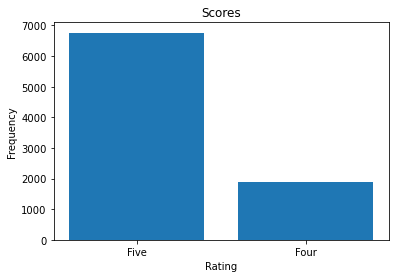

In [459]:
x = [reviews_df['Rating'].value_counts().index[i] for i in range(len(reviews_df['Rating'].value_counts()))]
y = list(reviews_df['Rating'].value_counts())

plt.bar(x, y)
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Scores')
plt.show()

<p> <i> Not much can be derived from the score ratings since it conveys a positive product </i></p>

<p>2. Graph of Location Centers and review frequencies</p>

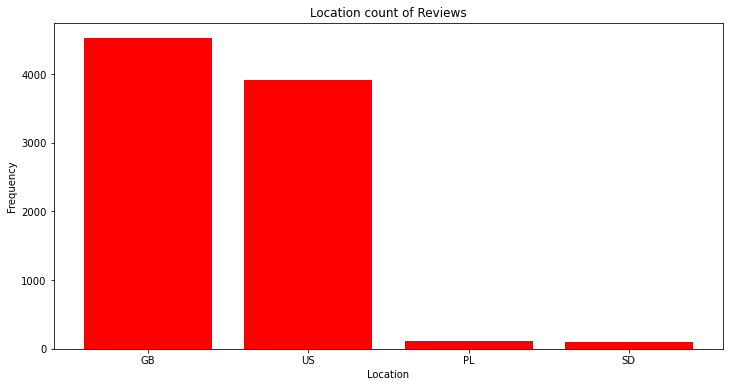

In [460]:
x = [reviews_df['Location'].value_counts().index[i] for i in range(len(reviews_df['Location'].value_counts()))]
y = list(reviews_df['Location'].value_counts())

plt.figure(figsize=(12,6))
plt.bar(x, y, color='r')
plt.xlabel('Location')
plt.ylabel('Frequency')
plt.title('Location count of Reviews')
plt.show()

<p> <i>Most product review were based in the GB </i></h3>

In [461]:
reviews_df['Emotion'].value_counts()

positive    6814
negative    1846
Name: Emotion, dtype: int64

<p> 3. Sentiment Count </p>

Rectangle(xy=(-0.4, 0), width=0.8, height=6814, angle=0)
Rectangle(xy=(0.6, 0), width=0.8, height=1846, angle=0)


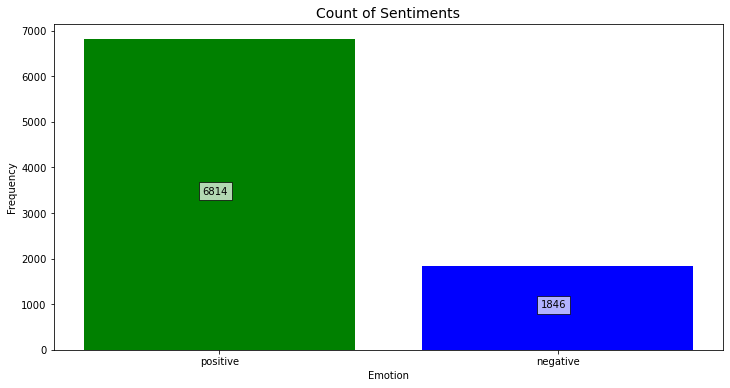

In [462]:
x = [reviews_df['Emotion'].value_counts().index[i] for i in range(len(reviews_df['Emotion'].value_counts()))]
y = list(reviews_df['Emotion'].value_counts())

plt.figure(figsize=(12,6))
labels = plt.bar(x, y, color=['g', 'b', 'r'])
for i in labels:
    print(i)
    plt.text(i.get_x() + 0.35, i.get_y() + i.get_height()/2, i.get_height(), bbox=dict(alpha=0.7, facecolor='white'))
plt.xlabel('Emotion')
plt.ylabel('Frequency')
plt.title('Count of Sentiments', fontsize=14)
plt.show()

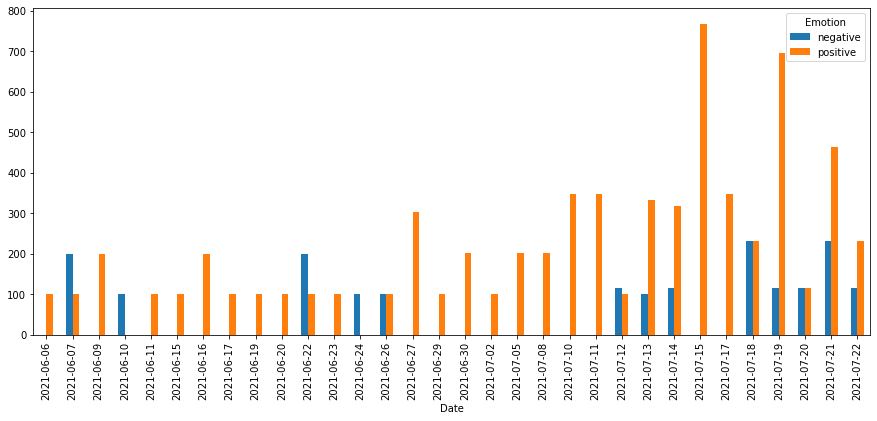

In [463]:
df_label_count = pd.DataFrame(reviews_df.groupby(['Date', 'Emotion'])['Emotion'].count())
df_label_count = df_label_count.unstack(level=-1)
df_label_count = df_label_count.xs('Emotion', axis='columns')
df_label_count = df_label_count[['negative', 'positive']].fillna(0)
df_label_count.plot(kind='bar', figsize=(15, 6))
plt.show()

<p><b> More number of positive emotions were conveyed through the surveys, while negative reviews were minimal. This will cause severe imbalance in classification.</b> </p>
<li> ~70% of data belongs to positive reviews </li>
<li> ~22% of data belongs to negative reviews </li>

<h3> A heavy imbalance between positive and negative/neutral statements.</h3>
<h4> We are going to build a sample containing similar distribution of positive, negative reviews </h4>


In [464]:
positive_df = reviews_df[reviews_df['Label'] == 1]
negative_df = reviews_df[reviews_df['Label'] == -1]

positive_sample = positive_df.sample(n=1846)

reviews_balanced = pd.concat([positive_sample, negative_df], axis=0)
reviews_balanced

,User,Review,Location,Rating,Date,Sentiment Scores,Compound Score,Emotion,Label
3942,Kay,good price fast delivery problem shipping comp...,US,Four,2021-06-30,"{'neg': 0.143, 'neu': 0.529, 'pos': 0.328, 'co...",0.5423,positive,1
3861,Todd,easy order great selection ice maker day,US,Five,2021-07-05,"{'neg': 0.0, 'neu': 0.417, 'pos': 0.583, 'comp...",0.7906,positive,1
4556,Mrs Rosemary Wilson,order simple effective forward receive,GB,Five,2021-07-19,"{'neg': 0.0, 'neu': 0.563, 'pos': 0.437, 'comp...",0.4767,positive,1
7425,Customer,excellent rate website order experience physic...,GB,Five,2021-07-21,"{'neg': 0.0, 'neu': 0.654, 'pos': 0.346, 'comp...",0.5719,positive,1
6421,Jim,place order beliani impressed quality outdoor ...,GB,Four,2021-07-22,"{'neg': 0.058, 'neu': 0.504, 'pos': 0.439, 'co...",0.8910,positive,1
...,...,...,...,...,...,...,...,...,...
8637,Frank,pay transportation warrantychecked basically w...,GB,Four,2021-07-19,"{'neg': 0.113, 'neu': 0.887, 'pos': 0.0, 'comp...",-0.1027,negative,-1
8639,Jane S,£ delivery address main route,GB,Four,2021-07-18,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,negative,-1
8640,Bruno Antoniotti,attempt recognise detail didn’t item i’d give,GB,Four,2021-07-18,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,negative,-1
8650,Jason Williamson,recently complain handle beth suter natalie ke...,GB,Four,2021-07-14,"{'neg': 0.363, 'neu': 0.571, 'pos': 0.066, 'co...",-0.8999,negative,-1


Rectangle(xy=(-0.4, 0), width=0.8, height=1846, angle=0)
Rectangle(xy=(0.6, 0), width=0.8, height=1846, angle=0)


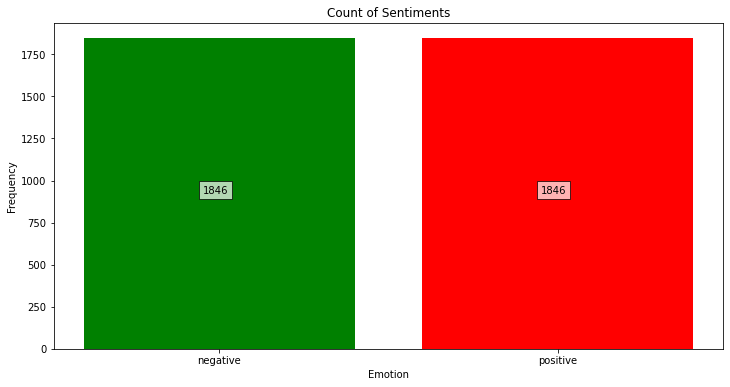

In [465]:
x = [reviews_balanced['Emotion'].value_counts().index[i] for i in range(len(reviews_balanced['Emotion'].value_counts()))]
y = list(reviews_balanced['Emotion'].value_counts())

plt.figure(figsize=(12,6))
labels = plt.bar(x, y, color=['g', 'r'])
for i in labels:
    print(i)
    plt.text(i.get_x() + 0.35, i.get_y() + i.get_height()/2, i.get_height(), bbox=dict(alpha=0.7, facecolor='white'))
plt.xlabel('Emotion')
plt.ylabel('Frequency')
plt.title('Count of Sentiments')
plt.show()

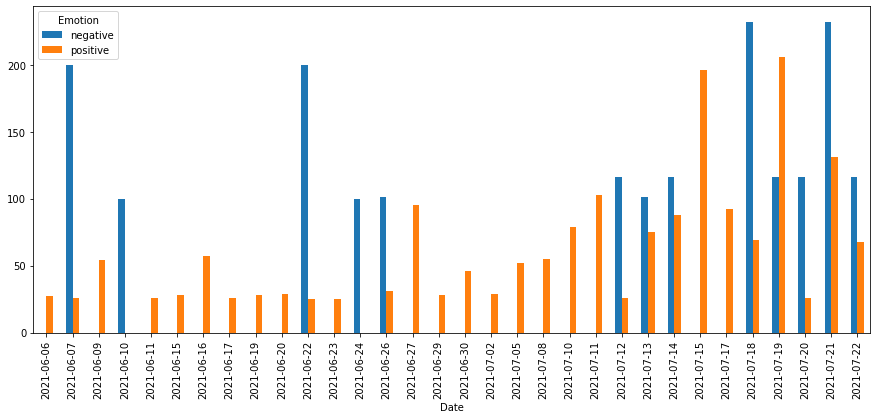

In [466]:
df_label_count = pd.DataFrame(reviews_balanced.groupby(['Date', 'Emotion'])['Emotion'].count())
df_label_count = df_label_count.unstack(level=-1)
df_label_count = df_label_count.xs('Emotion', axis='columns')
df_label_count = df_label_count[['negative', 'positive']].fillna(0)
df_label_count.plot(kind='bar', figsize=(15, 6))
plt.show()

In [467]:
positive_df = reviews_balanced[reviews_balanced['Emotion'] == 'positive']
negative_df = reviews_balanced[reviews_balanced['Emotion'] == 'negative']

pos_wc = WordCloud(width=800, height=800, background_color='black', max_words = 10).generate(str(positive_df['Review']))
neg_wc = WordCloud(width=800, height=800, background_color='black', max_words = 10).generate(str(negative_df['Review']))

<h4> Positive Word Cloud </h4>

(-0.5, 799.5, 799.5, -0.5)

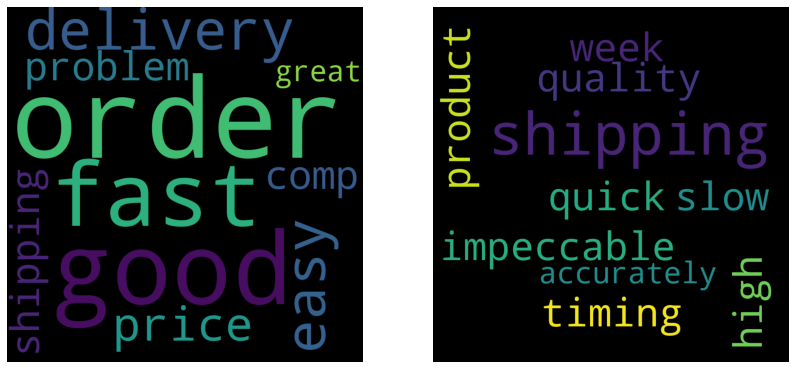

In [468]:
fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(1,2,1)
ax.imshow(pos_wc)
ax.axis('off')
ax = fig.add_subplot(1,2,2)
ax.imshow(neg_wc)
ax.axis('off')

<p><b> There are some positive words such as 'fantastic', 'great' and 'fast' suggesting, good prompt service </b></p>

<h3> Train and Test split </h3>

In [469]:
x_df = list(reviews_balanced['Review'])
y_df = list(reviews_balanced['Label'])

x_train, x_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.2, random_state=42)

In [470]:
print(f"Length of training data: {len(x_train)} x {len(y_train)}")
print(f"Length of testing data: {len(x_test)} x {len(y_test)}")

Length of training data: 2953 x 2953
Length of testing data: 739 x 739


<h3> Applying TF-IDF vectorizer to generate word embedding based on word importance in corpus </h3>

In [471]:
tfidf = TfidfVectorizer(use_idf=True, lowercase=True, strip_accents='ascii', stop_words=set(stopwords.words('english')))
x_tfidf = tfidf.fit_transform(x_train)
print(f"Dimensions of tf-idf model: {x_tfidf.shape}")
print()

Dimensions of tf-idf model: (2953, 335)



In [472]:
df_tfidf = pd.DataFrame(x_tfidf.toarray(), columns=tfidf.get_feature_names())

In [473]:
df_tfidf.head()

,absolutely,account,accurately,acd,acitydiscount,additional,addon,address,afternoon,agree,...,web,website,week,weird,william,work,write,xxl,yay,year
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.629071,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.424173,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<h3>ML training</h3>
<h4> Naive Bayes classifier </h4>

In [475]:
clf = MultinomialNB()
clf.fit(x_tfidf, y_train)
joblib.dump(clf, 'model_nb.pkl')

# clf = joblib.load('model_nb.pkl')

['model_nb.pkl']

<h3>ML performance evaluation </h3>

In [480]:
xtest_transform = tfidf.transform(x_test)
prediction = clf.predict(xtest_transform)
score_nb = accuracy_score(y_test, prediction)
print(f"Accuracy Score: {score_nb*100}")
print()
print(classification_report(y_test, prediction))
print()
print(f"ROC-AUC score: {roc_auc_score(y_test, prediction)}")

Accuracy Score: 100.0

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00       348
           1       1.00      1.00      1.00       391

    accuracy                           1.00       739
   macro avg       1.00      1.00      1.00       739
weighted avg       1.00      1.00      1.00       739


ROC-AUC score: 1.0


<h3>Plotting confusion matrix </h3>

Confusion Matrix
[[348   0]
 [  0 391]]


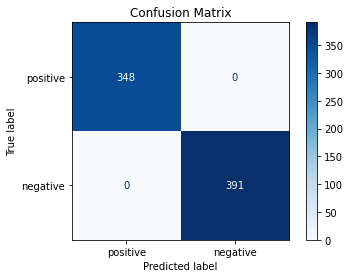

In [482]:
disp = plot_confusion_matrix(clf, xtest_transform, y_test,
                             display_labels=list(reviews_balanced['Emotion'].unique()),
                             cmap=plt.cm.Blues,
                             normalize=None)
disp.ax_.set_title("Confusion Matrix")

print("Confusion Matrix")
print(disp.confusion_matrix)

plt.show()

<h3> Building a Naive Bayes Classifier prediction function: predicting on new customer review </h3>

In [497]:
# Define a class that allows us to get a text and predict it's sentiment to see if it works. 

# 1. Ask for user input
# 2. Perform pre-processing steps to get into acceptable format
# 3. Convert into TF-IDF representation using the transform() function
# 4. Pass into ML model using predict() function
# 5. Once we get the output as '1', '-1' format, we convert it to respective sentiment, indicating a positive, negative
class sentimentAnalyzer:
    
    @staticmethod
    def preprocessing(msg):
        expanded = contractions(msg)
        post_punct = re.sub('[-,?;():_./\@#$%^&*{}<>+|0-9]',"", expanded)
        lemma = [word_lem.lemmatize(word, POS(word)) for word in post_punct.split()]
        post_stopword = [word for word in lemma if not word in stopwords_all]
        final_sent = " ".join(post_stopword)
        sentence_array = np.array([final_sent])
        vector = tfidf.transform(sentence_array)
        return vector

    
    @staticmethod
    def ml_predict(vec):
        prediction = clf.predict(vec)
        if prediction == 1:
            print("Thanks for the positive review! We hope you return soon to shop more!")
        else:
            feedback = input("Sorry for the inconvenience, caused to you! Is there anything we can change?: ")
            print("Thank you, we will forward this complaint to our management! Thank you!")
        
        
def message_sentiment():
    sa = sentimentAnalyzer()
    
    while True:
        inp = input("Please enter your review on Acity Furniture Store: ")
        if inp == 'quit':
            break
        try:
            processing = sa.preprocessing(inp)
            prediction = sa.ml_predict(processing)
        except ValueError:
            print('Please enter valid review')

<h3> Testing... </h3>

In [500]:
message_sentiment()

Please enter your review on Acity Furniture Store:  product was amazing


Thanks for the positive review! We hope you return soon to shop more!


Please enter your review on Acity Furniture Store:  product was terrible and slow
Sorry for the inconvenience, caused to you! Is there anything we can change?:  nothing


Thank you, we will forward this complaint to our management! Thank you!


Please enter your review on Acity Furniture Store:  quit
